In [1]:
import pandas as pd 
import numpy as np
import os
from joblib import dump
import pickle as pkl
import pickle
import itertools

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, precision_recall_curve
from sklearn.metrics import make_scorer, fbeta_score,  mean_squared_error, r2_score, f1_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, precision_recall_curve, classification_report, confusion_matrix)
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV, train_test_split, StratifiedShuffleSplit
from sklearn import datasets
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance

import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

recover; initial model generation and plot comparison, robertas code
running the final models, with eval threshold
compare test results in the end

In [14]:
train_df = pd.read_csv('/work/SarahHvidAndersen#6681/DataScience_project/data/train_df.csv')
eval_df = pd.read_csv('/work/SarahHvidAndersen#6681/DataScience_project/data/eval_df.csv')
test_df = pd.read_csv('/work/SarahHvidAndersen#6681/DataScience_project/data/test_df.csv')

selected_features = ['Fwd IAT Total', 'Fwd Packet Length Max',
        'Bwd Packet Length Mean', 'Bwd Packet Length Std',
        'Bwd Packets Length Total', 'Bwd Packet Length Max',
        'Packet Length Max', 'Packet Length Mean', 'Packet Length Std',
        'Packet Length Variance', 'Avg Packet Size', 'Fwd Header Length',
        'Avg Fwd Segment Size', 'Avg Bwd Segment Size']

X_train = train_df[selected_features]  # Features from the training data
y_train = train_df['Attack'] 

X_eval = eval_df[selected_features]  # Features from the evaluation data
y_eval = eval_df['Attack']

X_test = test_df[selected_features]
y_test = test_df['Attack']

In [3]:
# Initialize scaler
scaler = StandardScaler()

# Scale the features
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])

# Applying the 'trained' scaler on eval and test
X_eval[X_eval.columns] = scaler.transform(X_eval[X_eval.columns])
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])

/tmp/ipykernel_34265/809619830.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
/tmp/ipykernel_34265/809619830.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_eval[X_eval.columns] = scaler.transform(X_eval[X_eval.columns])
/tmp/ipykernel_34265/809619830.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

# baseline models

In [20]:
def run_on_splits(func):
    def _run_loop(model, model_name):
        for X, y, nsplit in zip([X_train, X_eval], 
                                [y_train, y_eval],  
                                ['train', 'val']):
            func(model, X=X, y=y, nsplit=nsplit, model_name=model_name, beta=2)  # F2 score optimization
    return _run_loop

In [21]:
@run_on_splits
def evaluate_splits(model, X, y, nsplit, model_name, beta=2):
    probabilities = model.predict_proba(X)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y, probabilities)

    # Calculating F scores for the given beta
    f_scores = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)
    best_idx = np.nanargmax(f_scores)  # Using nanargmax to ignore NaNs in the calculation
    best_threshold = thresholds[best_idx]

    predictions = (probabilities >= best_threshold).astype(int)

    # Calculate metrics
    acc = accuracy_score(y, predictions)
    prec = precision_score(y, predictions, zero_division=0)  # Handle zero division case
    rec = recall_score(y, predictions, zero_division=0)
    f1 = f1_score(y, predictions)
    f2 = (1 + 2**2) * (prec * rec) / ((2**2 * prec) + rec)
    roc_auc = roc_auc_score(y, probabilities) 

    # Store performances
    performances.append({
        'model': model_name,
        'split': nsplit,
        'threshold': best_threshold,
        'accuracy': acc,'precision': prec,'recall': rec,'f1': f1,
        'f2': f2,'roc_auc': roc_auc,'beta': beta})

    if nsplit == 'val':
        report = classification_report(y, predictions)
        cm = confusion_matrix(y, predictions)

        # Save the classification report as TXT
        report_path = f'../output/first_evaluation/{model_name}_classification_report.txt'
        with open(report_path, 'w') as f:
            f.write(report)

        # Generate and save onfusion matrix as JPEG
        fig, ax = plt.subplots(figsize=(4, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
        ax.set_title(f'Confusion Matrix for {model_name}')
        ax.set_xlabel('Predicted Labels')
        ax.set_ylabel('True Labels')
        ax.set_xticklabels(['Negative', 'Positive'])
        ax.set_yticklabels(['Negative', 'Positive'])
        plt.tight_layout()
        
        matrix_path = f'../output/first_evalutation/{model_name}_confusion_matrix.jpeg'
        plt.savefig(matrix_path)
        plt.close(fig)
        print(f"Saved confusion matrix for {model_name} at {matrix_path}")
    return

"""
def load_and_evaluate(model_filename, model_name):
model = load(model_filename)
evaluate(model, model_name=model_name)
"""

'\ndef load_and_evaluate(model_filename, model_name):\nmodel = load(model_filename)\nevaluate(model, model_name=model_name)\n'

In [ ]:
def train_and_save(model, X_train, y_train, filename):
    """Train a model and save it."""
    model.fit(X_train, y_train)
    dump(model, filename)
    return model

In [6]:
# specify baseline models, with tuning from gridsearch
models = {
    'Dummy_Classifier': DummyClassifier(strategy='most_frequent', random_state=42),
    'Baseline_log_reg': LogisticRegression(max_iter=1000, random_state=42),
    'Baseline_SVM': svm.SVC(kernel='linear', probability=True, random_state=42),
    'Baseline_KNN': KNeighborsClassifier(n_neighbors=10),
    'Baseline_RF': RandomForestClassifier(n_estimators=100, random_state=42),
    'Tuned_RF': RandomForestClassifier(n_estimators=110, max_depth=40, min_samples_leaf=1, min_samples_split=10, random_state=42),
    'Baseline_XGB': XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss'),
    'Tuned_XGB': XGBClassifier(objective='binary:logistic', use_label_encoder=False, colsample_bytree=1.0, gamma=0.5, learning_rate=0.3, max_depth=10, n_estimators=350, subsample=0.5, eval_metric='logloss')
}

trained_models = {}  # Dictionary to store trained model references

for name, model in models.items():
    trained_model = train_and_save(model, X_train, y_train, f'../models/first_models/{name}.joblib')
    trained_models[name] = trained_model  # Store the trained model for later use


/work/SarahHvidAndersen#6681/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/work/SarahHvidAndersen#6681/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/work/SarahHvidAndersen#6681/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

FileNotFoundError: [Errno 2] No such file or directory: '/work/SarahHvidAndersen#6681/DataScience_project/output/first_evalutation/Dummy_Classifier_confusion_matrix.jpeg'

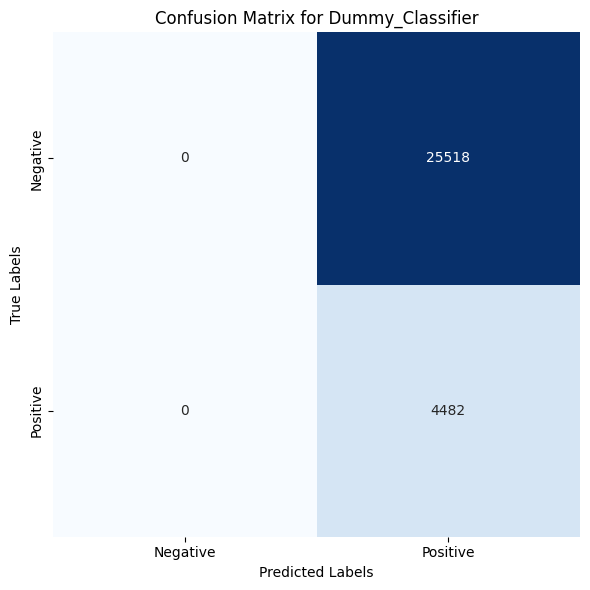

In [22]:
performances = []  # To store performance results

for name, model in trained_models.items():
    evaluate_splits(model, model_name=name)

verify results:

In [ ]:
# plotting
# if df path exists, use, otherwise create from performances

def plot_model_splits(performances, metric='f1'):
    # Create DataFrame from performances and filter val set
    perf_df = pd.DataFrame(performances)
    val_perf = perf_df[perf_df['split'] == 'val'].sort_values(by=metric, ascending=False)

    # sort the full DataFrame based on the order of the test set performance
    perf_df['model'] = pd.Categorical(perf_df['model'], categories=val_perf['model'], ordered=True)
    perf_df = perf_df.sort_values('model')

    # Set up the plot
    sns.set_style('whitegrid')
    scatter_plot = sns.scatterplot(data=perf_df, 
                                   y='model', 
                                   x=metric, 
                                   hue='split',
                                   style='split', 
                                   markers={       # Define markers for each split
                                       'train': 'o',
                                       'val': '^',
                                   },
                                   palette=['grey', 'darkorange'],
                                   alpha=0.8)  # Adjust alpha transparency for all markers

    scatter_plot.set_title('Model Performance Comparison')
    scatter_plot.set_xlabel(f'{metric.capitalize()} Score')
    scatter_plot.set_ylabel('Models')
    plt.show()

def plot_model_metric(perf_df, metric='f2'):
    #perf_df = pd.DataFrame(performances)
    
    # sort the full DataFrame based on the order of the test set performance
    perf_df['model'] = pd.Categorical(perf_df['model'], ordered=True)
    #perf_df = perf_df.sort_values('model')

    # Set up the plot
    sns.set_style('whitegrid')
    scatter_plot = sns.scatterplot(data=perf_df, 
                                   x=metric, 
                                   y='model',
                                   alpha=0.7)

    scatter_plot.set_title('Model Performance Comparison')
    scatter_plot.set_xlabel(f'{metric.capitalize()} Score')
    scatter_plot.set_ylabel('Models')
    plt.show()
    return perf_df

identify best models from baseline:

In [ ]:
# Create DataFrame from performances
perf_df = pd.DataFrame(performances)

# Filter for test split and sort by F2 score
top_models = perf_df[perf_df['split'] == 'val'].sort_values(by='f2', ascending=False).head(8)


In [ ]:
# loop over 'top_models' DataFrame and print cr and cm created above
for _, row in top_models.iterrows():
    model_name = row['model']
    # Construct paths based on how files were saved
    report_path = f'../output/{model_name}_classification_report.txt'
    matrix_path = f'../output/{model_name}_confusion_matrix.jpeg'

    # Load and print the classification report
    with open(report_path, 'r') as file:
        classification_report = file.read()
    print(f"Classification Report for {model_name}:\n{classification_report}")

    # Display the confusion matrix image
    img = mpimg.imread(matrix_path)
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

    print(f"Confusion matrix for {model_name} not found at {matrix_path}")

# best models

In [ ]:
def train_and_save(model, X_train, y_train, filename):
    """Train a model and save it to a specified filename."""
    model.fit(X_train, y_train)
    dump(model, filename)
    return model

def optimize_threshold(model, X, y, beta=2):
    probabilities = model.predict_proba(X)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y, probabilities)
    f_scores = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)
    best_idx = np.nanargmax(f_scores)
    best_threshold = thresholds[best_idx]
    return best_threshold

def evaluate_and_save(model, y, predictions, probabilities, best_threshold, model_name, feature_subset):
    acc = accuracy_score(y, predictions)
    prec = precision_score(y, predictions, zero_division=0)
    rec = recall_score(y, predictions, zero_division=0)
    f1 = f1_score(y, predictions, zero_division=0)
    f2 = (1 + 2**2) * (prec * rec) / ((2**2 * prec + rec))
    roc_auc = roc_auc_score(y, probabilities)

    # appending results
    performances.append({
        'model': model_name,
        'features': feature_subset,
        'threshold': best_threshold, 'accuracy': acc,'precision': prec,'recall': rec,
        'f1': f1,'f2': f2,'roc_auc': roc_auc})
    
    report = classification_report(y, predictions)
    cm = confusion_matrix(y, predictions)

    # Save the classification report as TXT
    report_path = f'../output/final_models/{model_name}_classification_report.txt'
    with open(report_path, 'w') as f:
        f.write(report)

    # Generate and save onfusion matrix as JPEG
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(f'Confusion Matrix for {model_name}')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_xticklabels(['Negative', 'Positive'])
    ax.set_yticklabels(['Negative', 'Positive'])
    plt.tight_layout()
    
    matrix_path = f'../output/final_models/{model_name}_confusion_matrix.jpeg'
    plt.savefig(matrix_path)
    plt.close(fig)
    print(f"Saved confusion matrix for {model_name} at {matrix_path}")
    return

def process_model(model, feature_subset, X_train, y_train, X_val, y_val, X_test, y_test, model_name):
    # Subset the features for the different datasets
    X_train_subset = X_train[feature_subset]
    X_val_subset = X_val[feature_subset]
    X_test_subset = X_test[feature_subset]

    # Train the model
    filename = f"../models/final_models/{model_name}_model.joblib"
    trained_model = train_and_save(model, X_train_subset, y_train, filename)

    # Optimize threshold on validation set
    best_threshold = optimize_threshold(trained_model, X_val_subset, y_val)

    # Apply model to the test set using the optimized threshold
    probabilities = trained_model.predict_proba(X_test_subset)[:, 1]
    predictions = (probabilities >= best_threshold).astype(int)

    # create predictions and save results
    evaluate_and_save(trained_model, y_test, predictions, probabilities, best_threshold, model_name, feature_subset)
    return

In [ ]:
models = {
    'Baseline_RF': RandomForestClassifier(n_estimators=100, random_state=42),

    'Tuned_RF': RandomForestClassifier(n_estimators=110, max_depth = 40, min_samples_leaf=1,
                                        min_samples_split = 10, random_state=42),

    'Baseline_XGB': XGBClassifier(objective='binary:logistic', use_label_encoder=False),

    'Tuned_XGB': XGBClassifier(objective='binary:logistic',use_label_encoder=False,
                                colsample_bytree=1.0, gamma=0.5,learning_rate=0.3, max_depth=10,
                                n_estimators=350, subsample=0.5, eval_metric='logloss') 
}

models_config = {
    'Tuned_RF_All_Features': ['Fwd IAT Total', 'Fwd Packet Length Max', 'Bwd Packet Length Mean', 'Bwd Packet Length Std',
                              'Bwd Packets Length Total', 'Bwd Packet Length Max', 'Packet Length Max', 'Packet Length Mean',
                              'Packet Length Std', 'Packet Length Variance', 'Avg Packet Size', 'Fwd Header Length',
                              'Avg Fwd Segment Size', 'Avg Bwd Segment Size'],
    'Tuned_RF_Selected_Features': ['Fwd IAT Total', 'Bwd Packet Length Std', 'Bwd Packets Length Total',
                                   'Packet Length Mean', 'Avg Packet Size', 'Fwd Header Length', 'Avg Fwd Segment Size',
                                   'Avg Bwd Segment Size'],
    'Tuned_XGB_Permutation_Features': ['Fwd IAT Total', 'Fwd Packet Length Max', 'Bwd Packet Length Mean', 'Bwd Packet Length Std',
                                       'Packet Length Std', 'Avg Packet Size', 'Fwd Header Length'],
    'Tuned_XGB_RFECV_Features': ['Fwd IAT Total', 'Fwd Packet Length Max', 'Bwd Packet Length Mean', 'Bwd Packet Length Std',
                                 'Bwd Packets Length Total', 'Bwd Packet Length Max', 'Packet Length Max', 'Packet Length Mean',
                                 'Packet Length Std', 'Packet Length Variance', 'Avg Packet Size', 'Fwd Header Length', 'Avg Fwd Segment Size']
}

performances = []

# Iterating over configurations
for model_name, features in models_config.items():
    # Extract the base model name (before the underscore)
    base_model_name = '_'.join(model_name.split('_')[:2])
    process_model(models[base_model_name], features, X_train, y_train, X_val, y_val, X_test, y_test, model_name)


# compare model vs test set predictions

In [ ]:
import pandas as pd
from joblib import load
# load best model, predict
# load threshold from eval


# Assuming 'top_models' DataFrame contains the paths or identifiers for your models
for _, row in top_models.iterrows():
    full_model_name = row['model']
    # Assuming the model name ends with '_1' and you want to remove this part
    model_name = "_".join(full_model_name.split('_')[:-1])  # Remove the last part after the last underscore
    
    model_path = f'../models/{model_name}.joblib'
    model = load(model_path)
    
    # Generate probability predictions
    probabilities = model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, probabilities)
    
    # Calculate F2 score for each threshold
    beta = 2
    f_scores = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)
    f_scores = np.nan_to_num(f_scores)  # Replace NaNs with zeros for safe max index finding
    best_idx = np.argmax(f_scores)  # Find index of the maximum F2 score
    best_threshold = thresholds[best_idx]  # Best threshold for maximum F2 score

    predictions = (probabilities >= best_threshold).astype(int)
    # Append predictions to the test DataFrame
    test_df[f'pred_{model_name}'] = predictions

# Now test_df has new columns for each model's predictions


In [ ]:
# Extract model names from the top_models DataFrame assuming the names are stored in a column named 'model'
model_names = top_models['model'].tolist()

# Filter for cases where the 'Attack' column is 1 and any model predicted 0
failed_cases = test_df[(test_df['Attack'] == 1) & (test_df.apply(lambda row: any(row[f'pred_{model_name}'] == 0 for model_name in model_names), axis=1))]

# Print the number of failed cases
print(f"Number of failed cases: {len(failed_cases)}")


In [ ]:
# Let's say the true labels column is named 'true_labels'
# Display cases where all models failed to predict correctly
failed_cases = test_df[test_df.apply(lambda row: all(row[f'pred_{model_name}'] != row['true_labels'] for model_name in top_models['model']), axis=1)]
print(failed_cases)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Plotting the first few instances where predictions differ
subset_df = test_df[test_df['true_labels'] != test_df[f'pred_{top_models.iloc[0]["model"]}']].head(10)  # Just an example to grab a few differing predictions
sns.barplot(data=subset_df, y='true_labels', x=subset_df.columns[1:], palette='viridis')
plt.title('Comparison of Predictions vs. True Labels')
plt.show()


In [ ]:
# Calculate value counts for the failed cases
failed_label_counts = failed_cases['Label'].value_counts()

# Calculate value counts for the entire test set
overall_label_counts = test_df['Label'].value_counts()

# Normalize value counts to compare proportions
failed_label_proportions = failed_cases['Label'].value_counts(normalize=True)
overall_label_proportions = test_df['Label'].value_counts(normalize=True)


In [ ]:
print("Failed Case Label Counts:")
print(failed_label_counts)
print("\nOverall Test Set Label Counts:")
print(overall_label_counts)

print("\nFailed Case Label Proportions:")
print(failed_label_proportions)
print("\nOverall Test Set Label Proportions:")
print(overall_label_proportions)
